# User Interface of the assignment of Research Track 2 #

Before starting to use this user interface, please run:
```console
$ roslaunch rt2_assignment jupyter_ass.launch
```

## Imports ##

In [1]:
import rospy
import jupyros as jr 
import ipywidgets as widgets
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from jupyros import ros3d
from ipywidgets import interactive_output
from geometry_msgs.msg import Twist
from rt2_assignment.srv import Command
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from actionlib_msgs.msg import GoalStatusArray
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MaxNLocator

# Import the autonomous_driving class of the package.
sys.path.append("../scripts/")
import autonomous_driving

## Initialization of the ROS node ##

In [2]:
# If ui is set to None, the autonomous_driving class does not print anything.
ui = None
rospy.init_node('driving_mode')                    # Initialize the ROS node.
ad = autonomous_driving.autonomous_driving(ui)     # Initialize the clas for autonomously drive the robot.
client = rospy.ServiceProxy("/command", Command)   # Initialize the client for the driver_assistance node.
rospy.wait_for_service("/command")                 # Waits until the driver_assistance node is ready.
publisher = jr.publish('/cmd_vel', Twist)          # Initialize a publisher to the cmd_vel topic.

### Subscriber to the laser scanner ###

In [3]:
laser_r, laser_theta = [], []   # Variables to plot the laser scanner.

def scanner_callback(msg):
    # This function updates the global variables laser_r and laser_theta when a new message arrives.
    global laser_r
    global laser_theta
    
    laser_r = msg.ranges
    laser_theta = np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment)
    
sub_laser = rospy.Subscriber('/scan', LaserScan, scanner_callback)

### Subscriber to the odometry ###

In [4]:
odom_x, odom_y = [], []   # Variables to plot the odometry.
 
def odom_callback(msg):
    # This function appends to the global variables odom_x and odom_y the new ones when a new message arrives.
    global odom_x
    global odom_y
    
    odom_x.append(msg.pose.pose.position.x)
    odom_y.append(msg.pose.pose.position.y)
    
sub_odom = rospy.Subscriber('/odom', Odometry, odom_callback)

### Subscriber to the status ###

In [5]:
colors, goal_list, feedback_list = ["white"], [0], [0]   # Variables to plot the goal history.

def status_callback(msg):
    # This function updates the global variables used to print the bar plot when a new message arrives.
    global colors
    adder = sum(feedback_list)   # Sum of feedbackcs until the last call of this function.
    
    if msg.status_list != []:    # If a goal was processed.
        n = msg.status_list[0].status   # Status of the goal.
    
        if len(colors) < ad.goal_counter + 1:   # If a new goal was sent, it increases the length of arrays.
            colors.append("blue")
            goal_list.append(ad.goal_counter)
            feedback_list.append(ad.feedback_counter - adder)
            
        else:   # It updates the value of the last goal's feedbacks.
            feedback_list[-1] = feedback_list[-1] + ad.feedback_counter - adder
        
        # It sets the color of the last bar depending on the goal status.
        if n == 1:
            colors[-1] = "blue"
        
        if n == 3:
            colors[-1] = "green"
            
        if n in [2, 4, 5, 8]:
            colors[-1] = "red"

sub_status = rospy.Subscriber('/move_base/status', GoalStatusArray, status_callback)

## Definition of widgets ##

In [6]:
# This widget displays the three driving modalities.
driving_mode = widgets.ToggleButtons(
    options=[('Autonomous driving', 1), ('Free drive', 2), ('Driver assistance', 3)],
    description='Choose:',
    value=1,
    disabled=False,
    button_style='',
)

# This widget asks for the x goal.
x_goal = widgets.FloatText(
    value=0,
    description='x goal:',
    disabled=False,
)

# This widget asks for the y goal.
y_goal = widgets.FloatText(
    value=0,
    description='y goal:',
    disabled=False,
)

# This widget shows the possible commands for the driver_assistance node.
driver_assistance = widgets.ToggleButtons(
    options=[('Increase speed', 'w'), ('Decrease speed', 's'), ('Turn left', 'a'), ('Turn right', 'd'),
             ('Stop linear', 'x'), ('Stop angular', 'z'), ('Stop sending', '0')],
    value='0',
    disabled=False,
    button_style='',
)

# This widget can change the zoom value for the laser scanner graphic.
zoom_slider = widgets.FloatSlider(
    value=10.0,
    min=1.0,
    max=20.0,
    step=0.1,
    description='Zoom:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

## User Interface ##

### Choose one of the following driving modalities: ###

In [7]:
display(driving_mode)

ToggleButtons(description='Choose:', options=(('Autonomous driving', 1), ('Free drive', 2), ('Driver assistanc…

### Drive the robot! ###

In [8]:
def ask_server(req):
    # Function binded with the driver_assistance widget to ask the server with the proper command.
    client(ord(req))
    
def ask_goal(b):
    # Function binded with the button "send goal", it calls the method reach_goal with the actual values of x_goal and y_goal
    # widgets, to send at the same time both values.
    ad.reach_goal(x_goal.value, y_goal.value)
    

def choice(mode):
    # Function binded with the driving_mode widget.
    # It shows the proper user interface for different driving modalities.
    
    # If the autonomous driving is processing a goal, send  cancel request.
    if ad.is_active is True:
        ad.cancel_goal()
    
    if mode == 1:        ### Autonomous driving mode selected. ###
        
        ask_server('1')   # Disable the driver_assistance node.
        button = widgets.Button(description="Send goal")
        display(x_goal)
        display(y_goal)
        display(button)
        button.on_click(ask_goal)   # Ask the autonomous_driving to reach the goal.

    if mode == 2:        ### Free drive mode selected. ###
        
        ask_server('1')   # Disable the driver_assistance node.
        display(publisher)
        
    if mode == 3:        ### Driver assistance mode selected. ###
        
        ask_server('0')   # Enable the driver_assistance node.
        display(driver_assistance)
        
interactive_output(ask_server, {'req': driver_assistance})
interactive_output(choice, {'mode': driving_mode})

Output()

### This is what the robot can see ###

In [9]:
v = ros3d.Viewer()
rc = ros3d.ROSConnection(url="ws://localhost:9090") 
tf_client = ros3d.TFClient(ros=rc, fixed_frame='map')
laser_view = ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client) 
map_view = ros3d.OccupancyGrid(topic="/map", ros=rc, tf_client=tf_client, continuous=True) 
path = ros3d.Path(topic="/move_base/NavfnROS/plan", ros=rc, tf_client=tf_client) 
urdf = ros3d.URDFModel(ros=rc, tf_client=tf_client, path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000')) 
g = ros3d.GridModel()
v.objects = [g, laser_view, map_view, path, urdf]
v

Viewer(objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090'), tf_client=TFClient(fixed_…

### Graphics of the robot's behavior ###

<IPython.core.display.Javascript object>


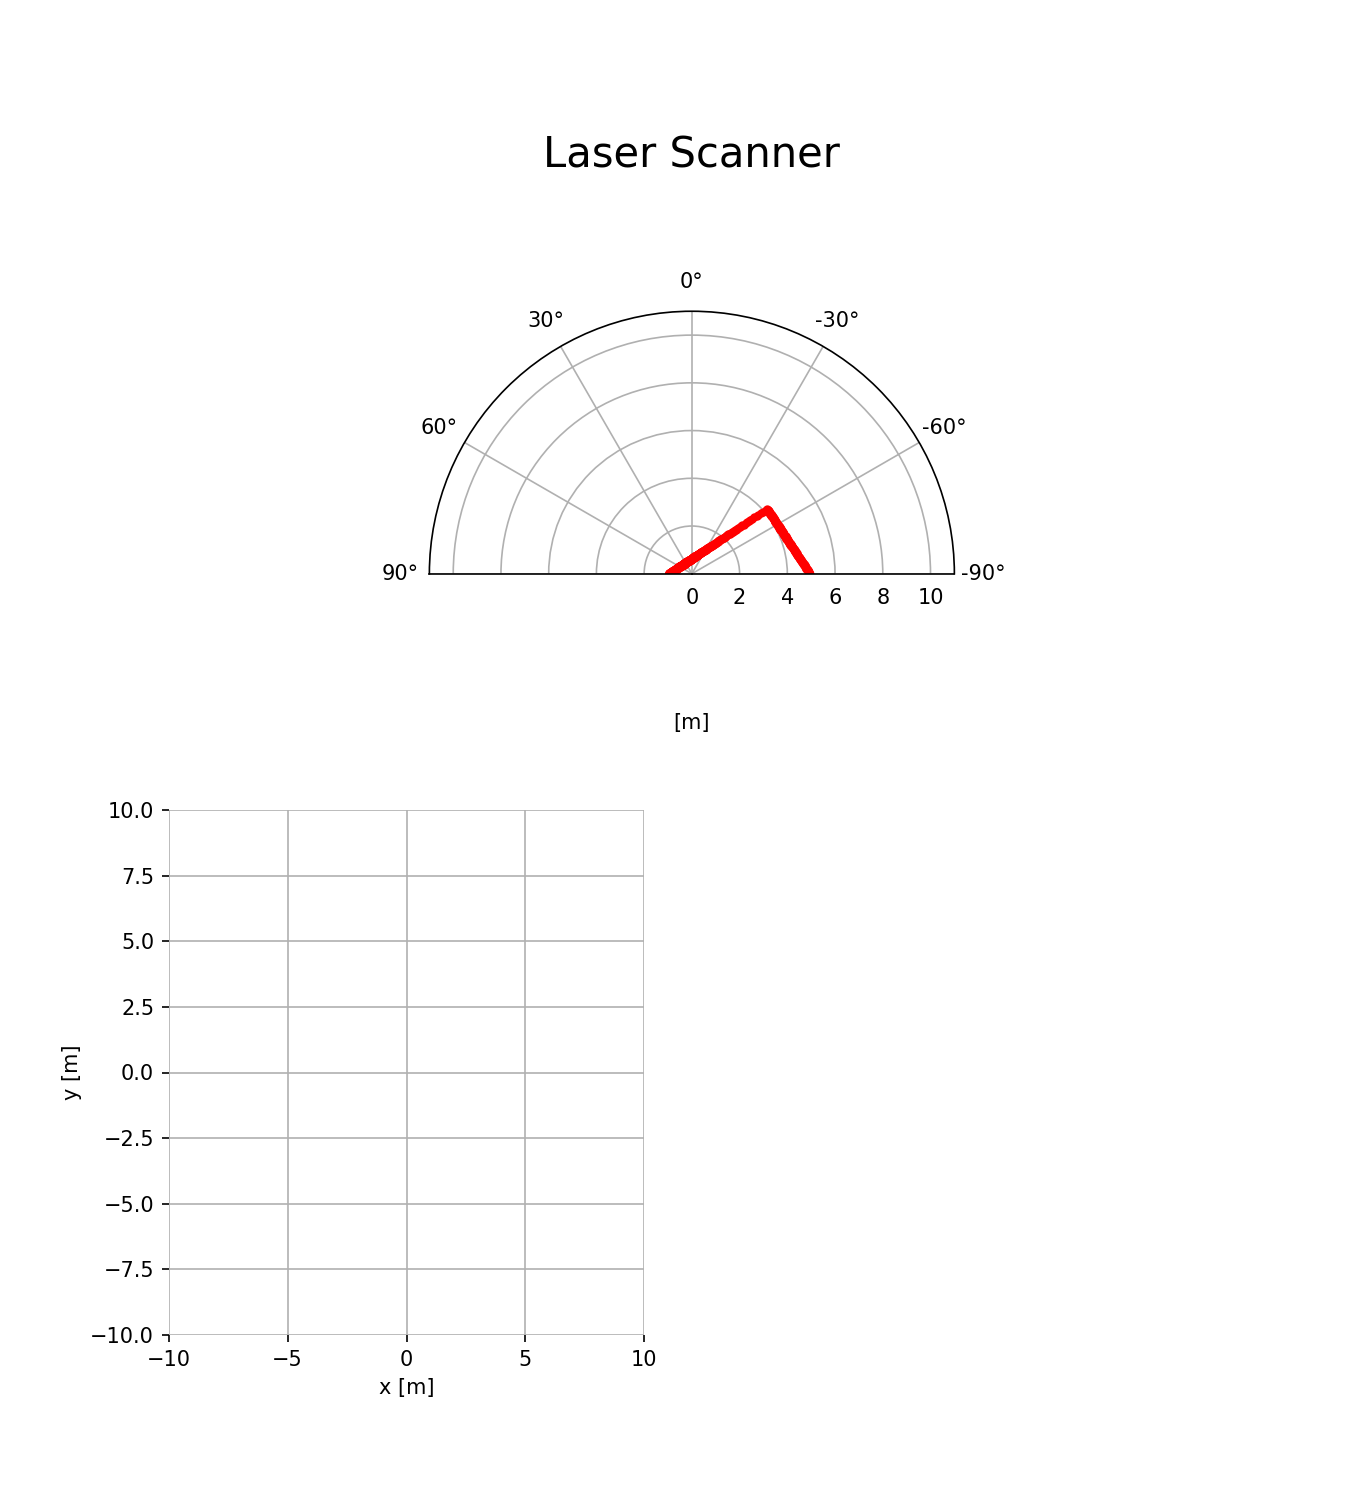

In [10]:
%matplotlib notebook

laser_rmax = 11   # Max radius of the laser scanner plot.

# Creates figure
fig = plt.figure(figsize=(9,10))

# Creates axes.
ax1 = plt.subplot(2, 2, (1, 2), projection='polar')   
ax2 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(2, 2, 4)
        
# Creates line objects for the plots
laser_ln, = ax1.plot([], [], 'r.')      
odom_ln, = ax2.plot([], [], 'ro')

def update_plot(frame):
    # This function, called by funcAnimation, updates the plots to animate them.
    
    # Set the new data of the laser scanner.
    laser_ln.set_xdata(laser_theta)
    laser_ln.set_ydata(laser_r)
    ax1.set_rmax(laser_rmax)   # Resize the max radius of the laser scanner plot.
    
    # Set the new data of the odometry.
    odom_ln.set_data(odom_x, odom_y)
    
    # Set the new data of the goal history.
    ax3.bar(goal_list[1::], feedback_list[1::], width=0.8, color=colors[1::])
    if feedback_list[-1] > 500:   # If the number of feedbacks is out of range, resize the plot y limit.
        ax3.set_ylim(0, feedback_list[-1] + 10)
    
def plot_init():
    # This function, called by funcAnimation, initilizes the plots.
    
    # Initialization of the laser scanner plot.
    ax1.set_title("Laser Scanner", fontsize=20)
    ax1.set_xlabel('[m]', fontsize=10)
    ax1.set_thetalim(-np.pi/2, np.pi/2)
    ax1.set_rmax(laser_rmax)
    ax1.set_theta_zero_location("N")
    
    # Initialization of the odometry plot.
    ax2.set_title("Odometry trajectory", fontsize=20)
    ax2.set_xlabel('x [m]', fontsize=10)
    ax2.set_ylabel('y [m]', fontsize=10)
    ax2.set_xlim(-10, 10) 
    ax2.set_ylim(-10, 10)
    ax2.grid()
    
    # Initialization of the goal history plot.
    ax3.set_title("Goal history", fontsize=20)
    ax3.set_xlabel('goal', fontsize=10)
    ax3.set_ylabel('feedbacks', fontsize=10)
    ax3.set_ylim(0, 500)
    ax3.grid(axis='y')
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Legend for the goal history plot.
    legend = {'goal reached':'green', 
              'goal canceled':'red', 
              'goal in progress':'blue'}         
    labels = list(legend.keys())
    handles = [plt.Rectangle((0,0),1,1, color=legend[label]) for label in labels]
    ax3.legend(handles, labels)

ani = FuncAnimation(fig, update_plot, init_func=plot_init, interval=500, blit=True)
plt.show()

Here you can zoom the laser scanner view:

In [11]:
class VisualiserScanner:
    
    def __init__(self):
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': 'polar'})
        self.ln, = plt.plot([], [], 'r.') 
        self.r, self.theta = [], []
        self.rmax = 10
        
    def plot_init(self):
        self.ax.set_thetalim(-np.pi/2, np.pi/2)
        self.ax.set_rmax(self.rmax)
        self.ax.set_theta_zero_location("N")
        return self.ln
        
    def scanner_callback(self, msg):
        self.r = msg.ranges
        self.theta = np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment)
        
    def update_plot(self, frame):
        for artist in plt.gca().lines + plt.gca().collections:
            artist.remove()
            
        self.ln = plt.plot(self.theta, self.r, 'r.')
        self.ax.set_rmax(self.rmax)
        
        return self.ln
    
    def zoom(self, zoom):
        self.rmax = zoom

In [12]:
def zoom(zoom):
    # Function binded with the zoom_slider widget to update the global variable laser_rmax.
    global laser_rmax
    laser_rmax = 21 - zoom   # The more zoom, the less radius shown; such as 1 < laser_rmax < 20.

interactive_output(zoom, {'zoom': zoom_slider})
display(zoom_slider)

FloatSlider(value=10.0, continuous_update=False, description='Zoom:', max=20.0, min=1.0, readout_format='.1f')